# Temporal And Spatial Analysis of Downtown Homeless Sleepers

This analysis uses the Data Library's San Diego Homeless Sleeper's dataset to explore homelessness in downtown San Diego


In [1]:
try:
    import metapack
except ModuleNotFoundError:
    !pip install -q -U git+https://github.com/Metatab/metapack#egg=metapack
    !mp config

In [2]:
import seaborn as sns
import metapack as mp
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [3]:
#pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-dowtown_homeless.csv')

pkg

# Downtown San Diego Homeless Sleepers
`sandiegodata.org-dowtown_homeless-2.1.1` Last Update: 2022-04-20T20:32:39

_Five years of monthly geographic positions for homeless sleepers in Downtown San Diego_


This dataset provides geographic locations for homeless sleepers in Downtown San Diego, as counted by enumerators from the Downtown San Diego Partnership. These counts have been done monthly since 2012, and this dataset provides counts since 2014. 

<center><a
href="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless
-Sleepers.png"><img
src="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless-
Sleepers.png" width="400px"></a></center>


The count is done on paper maps with handwritten count marks. The San Diego
Regional Data Library's [Downton Homelessness
project](http://downtown-homelessness.sandiegodata.org/) converted these
scanned count maps using a [web based image annotation
tool](http://www.robots.ox.ac.uk/~vgg/software/via/).

## Base and Imputed Datasets

This distribution has two version of the homeless counts, the base set,
``homeless_counts``, which has three months of missing data, and the imputed
dataset, ``imputed_counts`` in which these three missing months, 2014-08,
2014-09, and 2015-06 are probabilistically re-created.

The Imputation process uses the total count for the month, from the
``monthly_totals`` dataset, as the number of sleepers that the imputed month
will have. Then, the imputation process collects at least 1,000 records with
dates near the missing month into a sample set, calculating the portion of
records that are in each census block. Then the algorithm randomly selects that
number of records for each census block, and adjusts random blocks so the total
of the whole set of selected records is equal to the official count for the
month.

The result is an imputed month that has the same number of records as the
official count for the month and as the same portion of sleepers in each census
block as in adjacent months.

## Notes

Notes for the source dataset, as of April 2019:

The preliminary methodology (shown in yellow) [ March 2017 and earlier] counted
two individuals per tent and two individuals per vehicle.

On April 27, 2017, the Clean & Safe program adopted the counting methodology
used by the Regional Task Force on the Homeless. Per the methodology
(represented above by the dark green cells), [April 2017 to April 2018,
inclusive ] Clean & Safe staff counted 1.75 individuals per visible
tent/structure and 1.66 individuals per vehicle that showed clear signs of
habitation.

In May 2018, the Regional Task Force on the Homeless updated the methodology
for vehicles to 2.03 that shows clear signs of habitation (the methodology of
1.75 individuals per tent/structure remained the same). The Clean & Safe
program implemented this methodology on May 31, 2018 (represented in orange).

\* Denotes the months that The Downtown Fellowship of Ministries and Churches collaborated with us on the monthly homeless sleep count.

\*\*East Village breakout areas include the following:
    * North East East Village is the area north of Market Street & east of Park Ave. 
    * North West is the area north of Market Street & west of Park Ave.
    * South East is the area east of Park Ave. south of Market Street
    * South West is the area west of Park Ave. south of Market Street

## Caveats

Because this data is extracted, manually, from manually recorded maps, there
are a lot of quality issues. 

### Missing Months

Because of conversion errors and some complications with the source maps, there
are several months of data that are excluded from this dataset

* **August 2014**. In the original datasets, August 2014 was a duplicate of September 2014. 
* **September 2014**. Comfusion related to the duplication of September and August resulted in September being incompletely processed. 
* **June 2015**. All of the map images for this month were blank. An alternate source

In [4]:
mt = pkg.resource('monthly_totals').dataframe()
hc = pkg.resource('homeless_counts').dataframe()
hc['records'] = 1

ic = pkg.resource('imputed_counts').geoframe()
ic['records'] = 1

In [45]:
hc.groupby('type').records.sum()

type
individual    37052
structure      1968
vehicle         182
Name: records, dtype: int64

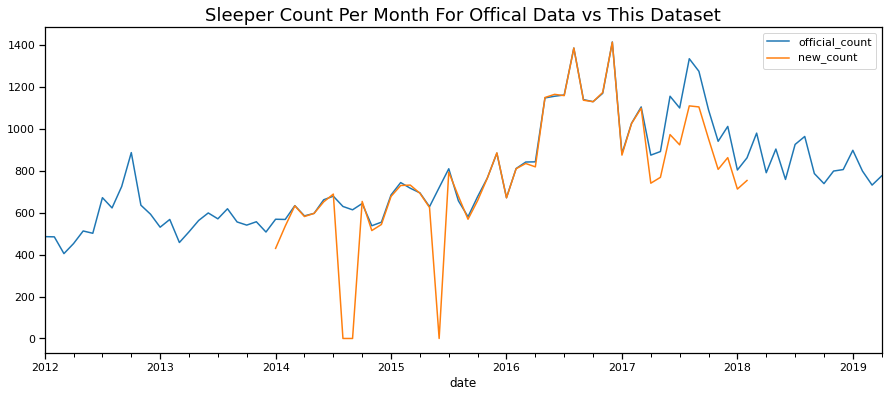

In [5]:
t = hc.set_index('date').groupby(pd.Grouper(freq="MS")).records.count().to_frame().rename(columns={'records':'new_count'})
mt = mt.set_index('date').groupby(pd.Grouper(freq="MS")).sum().rename(columns={'count':'official_count'})

j = mt.join(t)
ax = j.plot(figsize=(15,6))
ax.set_title('Sleeper Count Per Month For Offical Data vs This Dataset', fontsize=18);

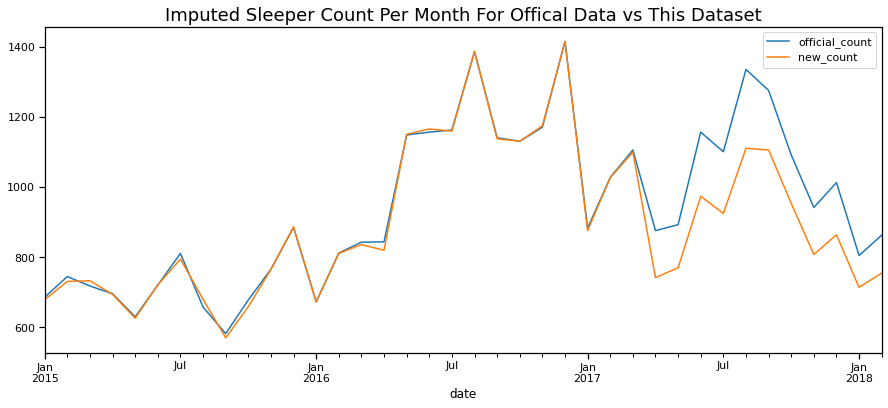

In [6]:

t = ic.set_index('date').groupby(pd.Grouper(freq="MS")).records.count().to_frame().rename(columns={'records':'new_count'})
mt = pkg.resource('monthly_totals').dataframe().set_index('date').groupby(pd.Grouper(freq="MS")).sum().rename(columns={'count':'official_count'})

j = mt.join(t)
ax = j.loc['2015':'2018-02-01'].plot(figsize=(15,6))
ax.set_title('Imputed Sleeper Count Per Month For Offical Data vs This Dataset', fontsize=18);


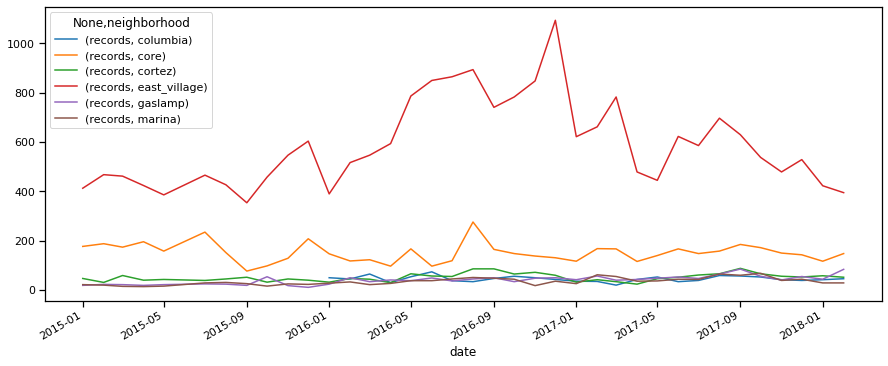

In [7]:

t = hc.set_index('date').groupby([pd.Grouper(freq="MS"), 'neighborhood']).records.count().to_frame()
t.unstack().loc['2015':'2018-02-01'].plot(figsize=(15,6));
ax.set_title('Imputed Count By Time and Neighborhood', fontsize=18);

# Geographic Analysis

In [8]:
# Blocks
blocks = pkg.resource('downtown_blocks').geoframe().rename(columns={'geoid10':'geoid'})
blocks = blocks[['geoid', 'geometry']]

In [37]:
# Homeless Counts

# The Homeless sleepers file already has block geoids, so we can do a non-spatial merge
# just to get the block geometry
t =  blocks.merge(ic[['geoid', 'records']], on='geoid').rename(columns={'records':'sleepers'})

# Since sleepers is a dummy variable, aggregation with sum is the same as count
hc_blocks = t.groupby('geoid').count().sleepers.to_frame()


,neighborhood,date,type,temp,rain,geoid,x,y,geometry,records
0,east_village,2014-01-01,individual,<NA>,NaN,10100US060730054004032,6.282334e+06,1.837657e+06,POINT (-117.15805 32.70541),1
1,east_village,2014-01-01,individual,<NA>,NaN,10100US060730051001005,6.284917e+06,1.839331e+06,POINT (-117.14970 32.71007),1
2,east_village,2014-01-01,individual,<NA>,NaN,10100US060730051001005,6.284917e+06,1.839331e+06,POINT (-117.14970 32.71007),1
3,east_village,2014-01-01,individual,<NA>,NaN,10100US060730051001005,6.284917e+06,1.839331e+06,POINT (-117.14970 32.71007),1
4,east_village,2014-01-01,individual,<NA>,NaN,10100US060730051001005,6.284917e+06,1.839331e+06,POINT (-117.14970 32.71007),1
...,...,...,...,...,...,...,...,...,...,...
41161,east_village,2018-02-21,individual,52,NaN,10100US060730054004016,6.282622e+06,1.839196e+06,POINT (-117.15715 32.70965),1
41162,east_village,2018-02-21,individual,52,NaN,10100US060730051002007,6.283475e+06,1.839397e+06,POINT (-117.15439 32.71022),1
41163,east_village,2018-02-21,individual,52,NaN,10100US060730051002012,6.283601e+06,1.838874e+06,POINT (-117.15396 32.70878),1
41164,east_village,2018-02-21,individual,52,NaN,10100US060730054004002,6.282194e+06,1.839597e+06,POINT (-117.15856 32.71074),1


In [10]:
# Businesses
businesses = mp.open_package('metatab+http://library.metatab.org/sangis.org-business_sites.csv').resource('business_sites').geoframe()
bus_blocks = gpd.sjoin(blocks, businesses).groupby('geoid').count().id.to_frame().rename(columns={'id':'businesses'})


In [12]:
import metapack as mp
pkg = mp.open_package('http://library.metatab.org/sandag.gov-crime-2007e2013-2.1.4.csv')

# Create Dataframes
crime = pkg.resource('incidents').geoframe()

In [13]:
crime.head().T

,0,1,2,3,4
datetime,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00
year,2007,2007,2007,2007,2007
month,1,1,1,1,1
day,1,1,1,1,1
week,1,1,1,1,1
dow,0,0,0,0,0
time,2020-11-25 00:00:00,2020-11-25 00:00:00,2020-11-25 00:00:00,2020-11-25 00:00:00,2020-11-25 00:00:00
hour,0,0,0,0,0
is_night,1,1,1,1,1
category,THEFT/LARCENY,THEFT/LARCENY,THEFT/LARCENY,FRAUD,FRAUD


In [18]:
# Crime types:
# ['THEFT/LARCENY', 'FRAUD', 'SEX CRIMES', 'VANDALISM', 'VEHICLE BREAK-IN/THEFT', 'BURGLARY', 'MOTOR VEHICLE THEFT',
#  'ROBBERY', 'DUI', 'ASSAULT', 'DRUGS/ALCOHOL VIOLATIONS', 'ARSON','WEAPONS', 'HOMICIDE']

t = crime[crime['category'].isin(['ASSAULT','VANDALISM'])]
t = gpd.sjoin(blocks, t)
t['crimes'] = 1
crime_blocks = t.groupby('geoid_left').count().crimes.to_frame()
crime_blocks.index.name = 'geoid'

In [25]:
# Pedestrians
ped = mp.open_package('http://library.metatab.org/sandiegodata.org-pedestrian-blocks-1.zip').resource('ped_blocks').dataframe()

# 6 is Saturday
# 3 is Monday
ped1 = ped[(ped.dow==6) & (ped.tod=='evening')].set_index(['geoid','tod'])[['density']].rename(columns={'density':'sat_eve_ped'}).reset_index()
ped2 = ped[(ped.dow==3) & (ped.tod=='lunch')].set_index(['geoid','tod'])[['density']].rename(columns={'density':'wed_lunch_ped'}).reset_index()
ped3 = ped[(ped.dow==3) & (ped.tod=='night')].set_index(['geoid','tod'])[['density']].rename(columns={'density':'wed_night_ped'}).reset_index()

#ped =ped[['geoid','rank']].rename(columns={'rank':'pedestrians'})
ped = ped1[['geoid','sat_eve_ped']]\
      .merge(ped2[['geoid','wed_lunch_ped']], on='geoid')\
      .merge(ped3[['geoid','wed_night_ped']], on='geoid')
        
df = blocks.merge(crime_blocks, on='geoid', how='left')\
           .merge(hc_blocks, on='geoid', how='left')\
           .merge(bus_blocks, on='geoid', how='left')\
           .merge(ped,on='geoid', how='left')\
           .fillna(0)


/Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


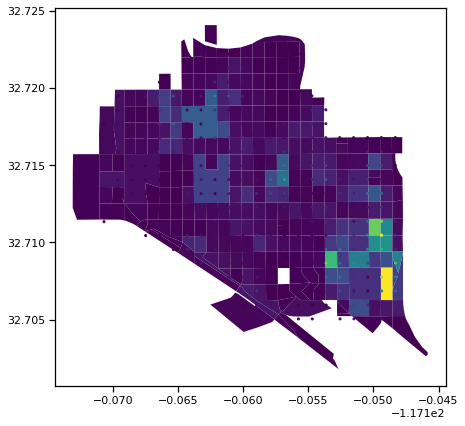

In [94]:
from shapely.geometry import Point
hc11 = ic.to_crs(32600 + 11)

# Quantize positions to 100 m^2
hc11['n'] = 1 # Dummy variable. 
hc11['x'] = hc11.geometry.apply(lambda g: (g.x+50) // 100 )
hc11['y'] = hc11.geometry.apply(lambda g: (g.y+50) // 100 )

t = hc11.groupby(['type','x','y']).agg({'n':'sum'}).reset_index()


t['geometry'] = t.apply(lambda r: Point(r.x*100, r.y*100), axis=1)
t = gpd.GeoDataFrame(t, crs = 32600 + 11)

sleepers_norm = df[['sleepers', 'geoid','geometry']].copy()

sleepers_norm['sleepers']  = sleepers_norm.sleepers / sleepers_norm.sleepers.max()

ax = sleepers_norm.plot(column='sleepers', figsize=(7,7))

tn = t[t['type'] == 'individual']
tn['nn'] = tn.n / tn.n.max()
tn = tn.to_crs(4326)
tn.plot(ax=ax, column='nn', markersize=4)


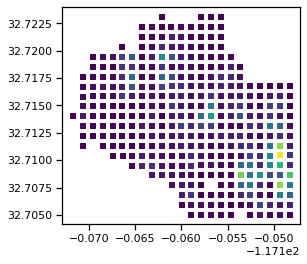

In [93]:
t.plot(column='nn', markersize=25, marker='s')

In [88]:
t.nn.describe().to_frame().join(sleepers_norm.sleepers.describe())

,nn,sleepers
count,331.000000,287.000000
mean,0.083879,0.061088
std,0.141769,0.114837
min,0.000713,0.000426
25%,0.011056,0.007666
50%,0.035663,0.021721
75%,0.083452,0.057496
max,1.000000,1.000000


## Correlations

Coarse correlations between blocks. Homelessness sleapers correlates a little with drug and alcohol crime, but not much else. 


In [26]:
df[['crimes','sleepers','businesses', 'sat_eve_ped', 'wed_lunch_ped', 'wed_night_ped']].corr()

,crimes,sleepers,businesses,sat_eve_ped,wed_lunch_ped,wed_night_ped
crimes,1.000000,0.162522,0.380548,0.163554,-0.012781,0.154023
sleepers,0.162522,1.000000,-0.006788,0.032697,0.084260,0.044335
businesses,0.380548,-0.006788,1.000000,0.131604,0.022841,0.188799
sat_eve_ped,0.163554,0.032697,0.131604,1.000000,0.229896,0.825919
wed_lunch_ped,-0.012781,0.084260,0.022841,0.229896,1.000000,0.486369
wed_night_ped,0.154023,0.044335,0.188799,0.825919,0.486369,1.000000


## Maps of All Variables

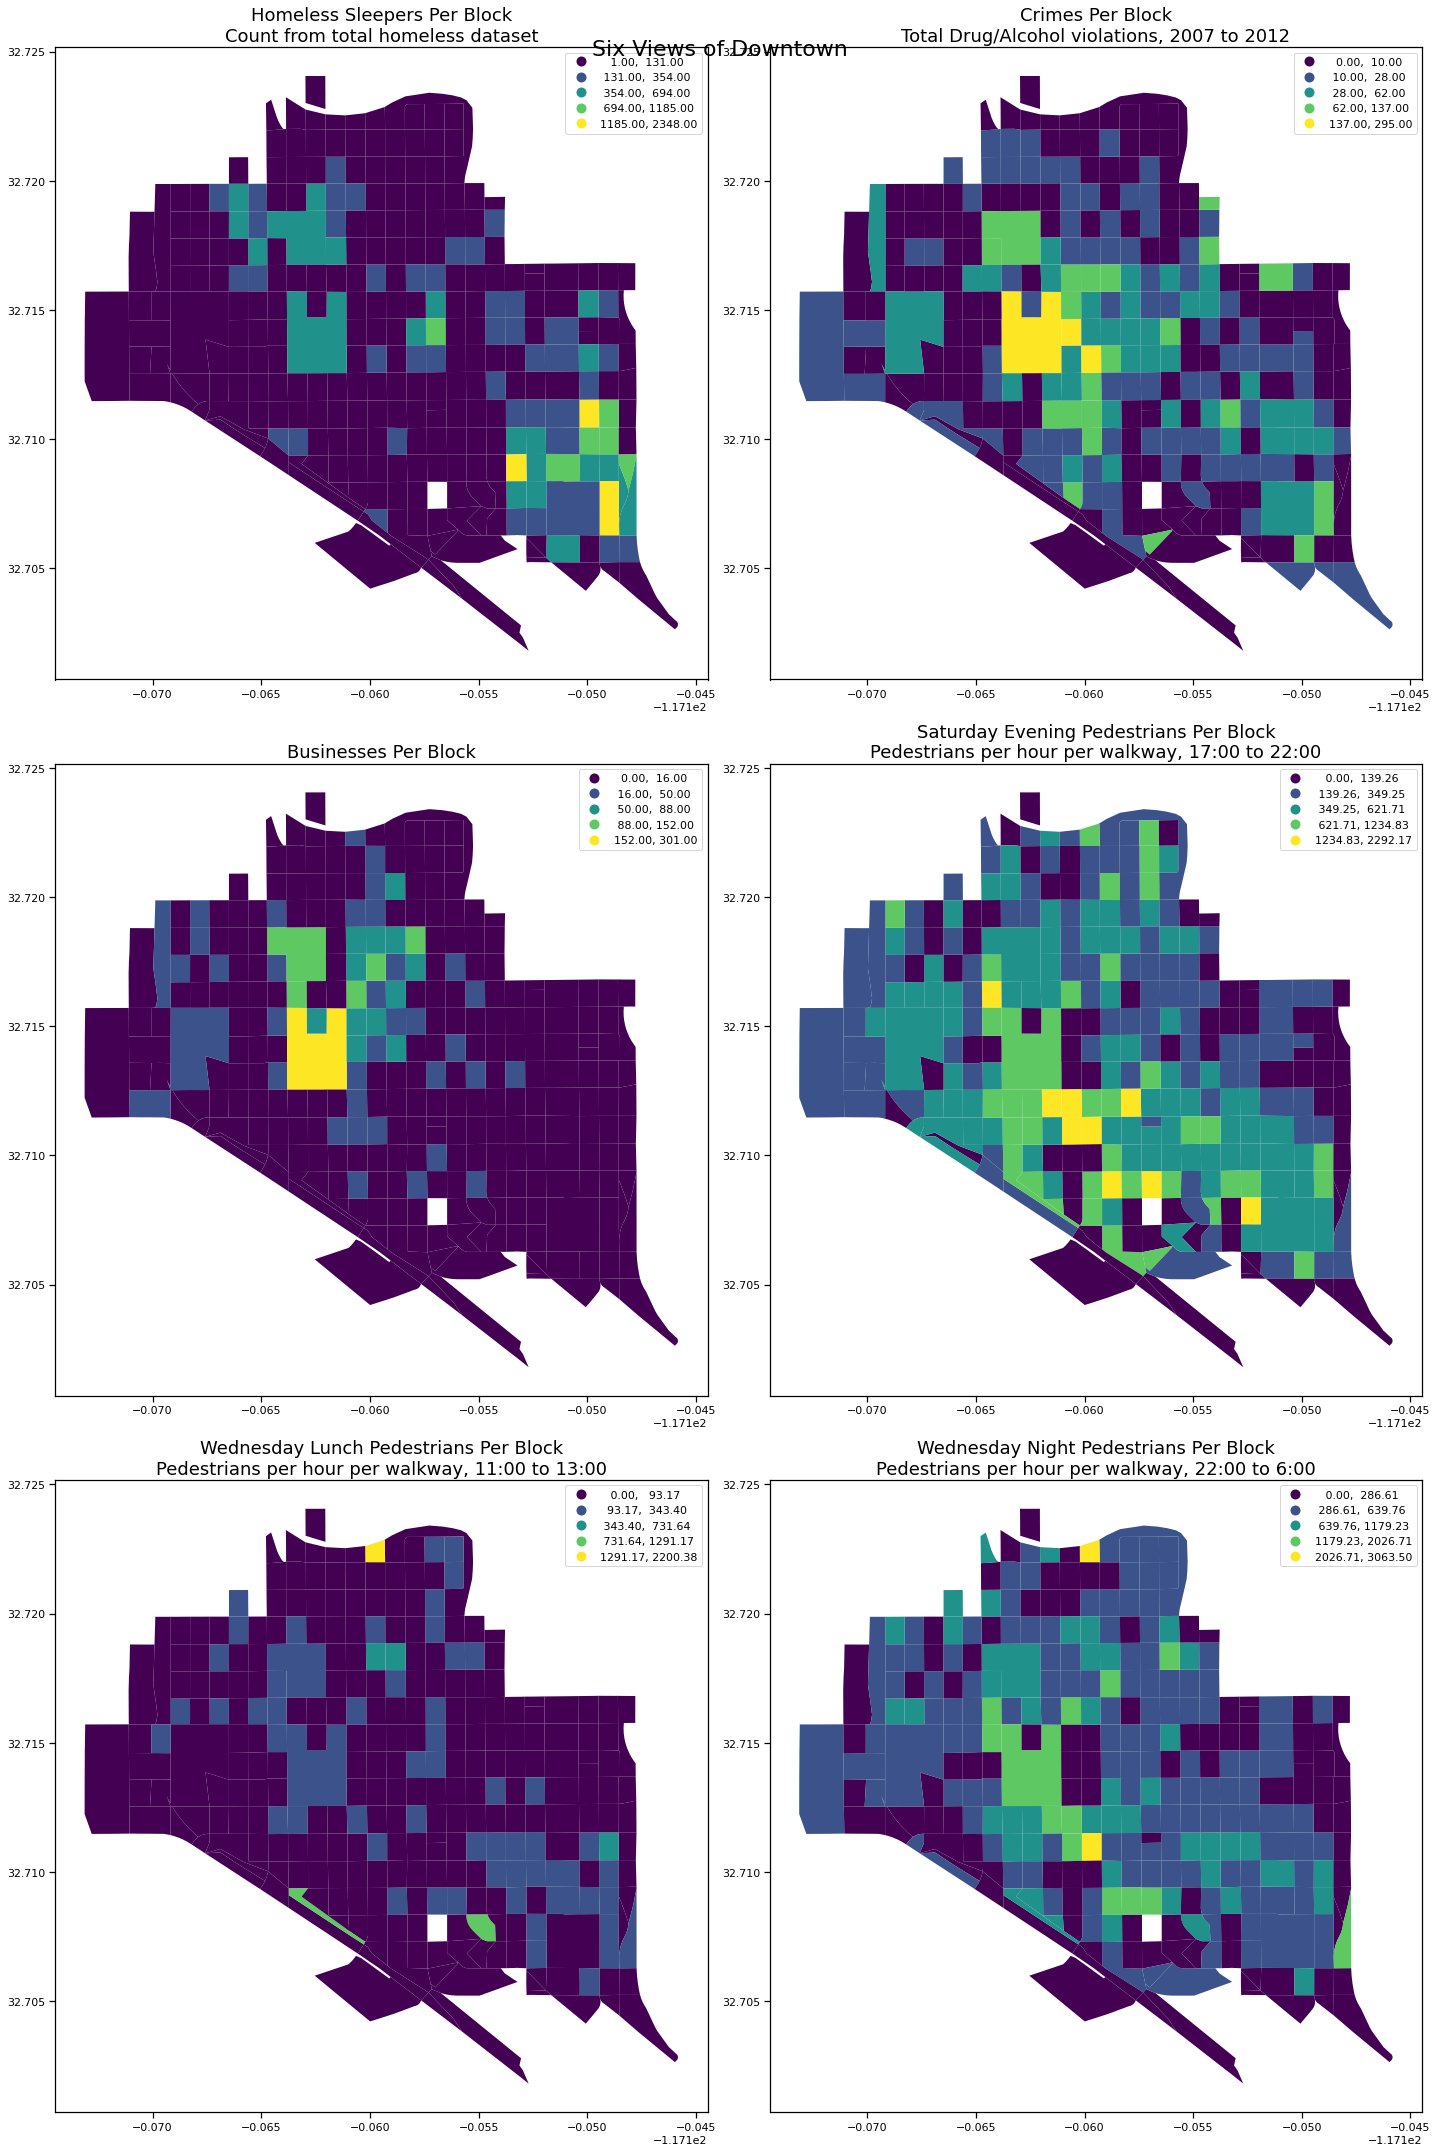

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(20,30))
axes = axes.flat

df.plot(ax=axes[0], column='sleepers', figsize=(10,10), scheme='fisher_jenks', legend=True);
axes[0].set_title("Homeless Sleepers Per Block\nCount from total homeless dataset", fontsize=18);

df.plot(ax=axes[1], column='crimes', figsize=(10,10), scheme='fisher_jenks', legend=True);
axes[1].set_title("Crimes Per Block\nTotal Drug/Alcohol violations, 2007 to 2012", fontsize=18);

df.plot(ax=axes[2], column='businesses', figsize=(10,10), scheme='fisher_jenks', legend=True);
axes[2].set_title("Businesses Per Block", fontsize=18);

df.plot(ax=axes[3], column='sat_eve_ped', figsize=(10,10), scheme='fisher_jenks', legend=True);
axes[3].set_title("Saturday Evening Pedestrians Per Block\nPedestrians per hour per walkway, 17:00 to 22:00", fontsize=18);

df.plot(ax=axes[4], column='wed_lunch_ped', figsize=(10,10), scheme='fisher_jenks', legend=True);
axes[4].set_title("Wednesday Lunch Pedestrians Per Block\nPedestrians per hour per walkway, 11:00 to 13:00", fontsize=18);

df.plot(ax=axes[5], column='wed_night_ped', figsize=(10,10), scheme='fisher_jenks', legend=True);
axes[5].set_title("Wednesday Night Pedestrians Per Block\nPedestrians per hour per walkway, 22:00 to 6:00", fontsize=18);

fig.suptitle('Six Views of Downtown', fontsize=22)
plt.tight_layout()


# Homeless Shelter Tent

In November 2017, the City of San Diego [opened a homeless tent at 1402 Commercial](https://www.nbcsandiego.com/news/local/Temporary-Homeless-Shelters-to-go-up-in-Three-San-Diego-Locations-457376853.html), in the South West corner of East Village. 


/Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization

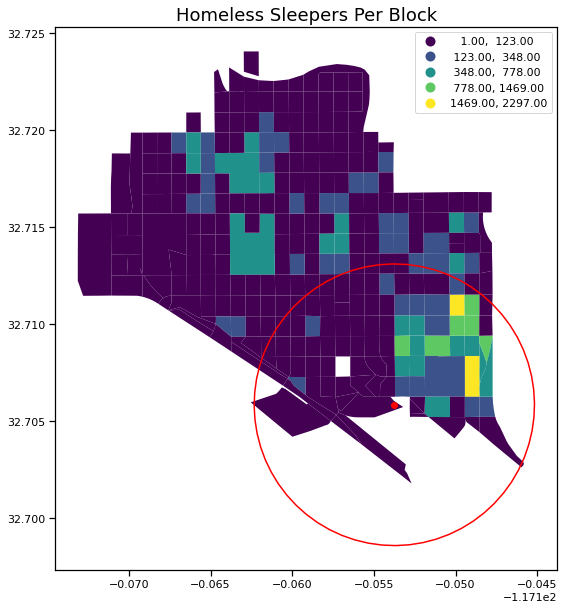

In [29]:

from shapely.geometry import Point

pt = gpd.GeoDataFrame([[Point(-117.1537487,32.705857)]], columns=['geometry'], geometry='geometry', crs={'init': 'epsg:4326'})

# Buffer point. Convert CRS to do the buffering in feet
pt_1000 =  gpd.GeoDataFrame({'geometry':pt.to_crs({'init':'epsg:2230'}).buffer(5280/2).to_crs({'init':'epsg:4326'})}, crs={'init': 'epsg:4326'})

j = blocks.merge(hc[['geoid','records']].groupby('geoid').agg({'records':'count'}).reset_index(), on='geoid')

ax = j.plot(column='records', figsize=(10,10), scheme='fisher_jenks', legend=True);

ax.set_title("Homeless Sleepers Per Block", fontsize=18);

pt_1000.geometry.boundary.plot(ax=ax, color='red')
pt.plot(ax=ax, color='red')

/Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


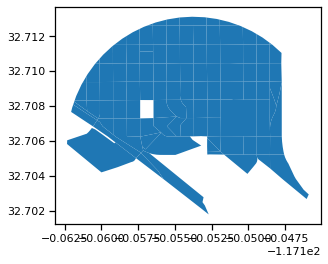

In [30]:
ints =  gpd.overlay(pt_1000, df, how='intersection')
ints.plot()

In [31]:
ints

,geoid,crimes,sleepers,businesses,sat_eve_ped,wed_lunch_ped,wed_night_ped,geometry
0,10100US060730054004017,7.0,6,6.0,538.583333,62.750000,618.125000,"POLYGON ((-117.15739 32.71065, -117.15739 32.7..."
1,10100US060730054004023,8.0,10,6.0,1710.666667,119.750000,1262.062500,"POLYGON ((-117.15736 32.70835, -117.15738 32.7..."
2,10100US060730054001014,74.0,13,13.0,0.000000,0.000000,0.000000,"POLYGON ((-117.16082 32.70832, -117.16027 32.7..."
3,10100US060730054001009,6.0,21,0.0,144.833333,12.000000,97.166667,"POLYGON ((-117.16198 32.70790, -117.16191 32.7..."
4,10100US060730052001037,44.0,43,4.0,495.203704,85.888889,555.138889,"POLYGON ((-117.15210 32.71154, -117.15265 32.7..."
...,...,...,...,...,...,...,...,...
100,10100US060730051002011,12.0,1601,6.0,728.555556,130.500000,873.666667,"POLYGON ((-117.15298 32.70837, -117.15354 32.7..."
101,10100US060730051002004,41.0,24,6.0,566.500000,43.142857,446.875000,"POLYGON ((-117.15647 32.71066, -117.15648 32.7..."
102,10100US060730051002003,0.0,23,8.0,883.857143,117.000000,945.321429,"POLYGON ((-117.15483 32.71045, -117.15538 32.7..."
103,10100US060730051001005,47.0,1172,0.0,539.533333,61.050000,406.700000,"POLYGON ((-117.14963 32.70941, -117.15017 32.7..."


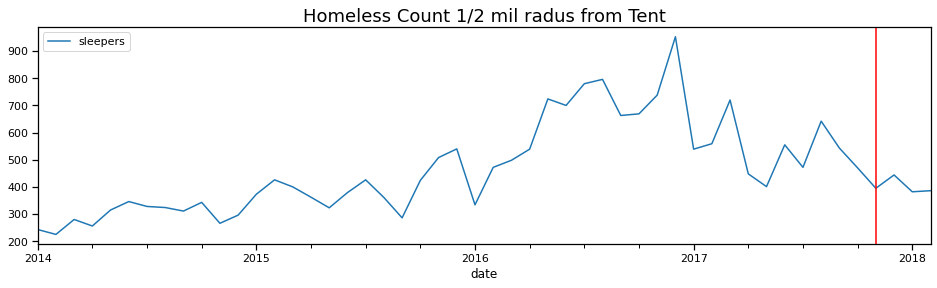

In [32]:
t = gpd.GeoDataFrame(ints[['geoid']].merge(ic, on='geoid'), geometry='geometry')
t = t[['records','date']].set_index('date').groupby(pd.Grouper(freq="MS")).sum().rename(columns={'records':'sleepers'})
ax = t.plot(figsize=(16, 4))
ax.axvline(x='2017-11-01', color='red');
ax.set_title('Homeless Count 1/2 mil radus from Tent', fontsize=18);

In [33]:
gpd.__version__

'0.10.2'